In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 设置参数
mpl.rcParams["pdf.fonttype"] = 42  # 保留字体
sc.settings.verbosity = 4  # 输出细节
sc._settings.ScanpyConfig.n_jobs = 100  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

7.去批次

- 7.1 读取标准化后的数据
- 7.2 取高变基因子集
- 7.3 scvi 去批次
- 7.4 Harmony 去批次
- 7.5 通过回归处理其他阻塞因素（可选）
- 7.6 保存

---

- 整合批次只是为了最终注释


In [3]:
## 7.1 读取标准化后的数据
adata = sc.read("anndata_highly.h5ad")
# print(adata.X.max(), adata.layers["log1p_norm"].max(), sep="\n")
print(adata.X.max(), adata.layers["scran_normalization"].max(), sep="\n")
adata

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


4380.0
8.844777397637154


AnnData object with n_obs × n_vars = 66568 × 2000
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'size_factors'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean

In [4]:
## 7.3 scvi去批次
"""
    - 变分自动编码器是一种试图降低数据集维数的人工神经网络。
    - 条件部分是指在特定协变量(在本例中为batch)上调节此降维过程，
    - 以便协变量不会影响低维表示。
    - scvi效果很好,但是需要原始counts数据
    - scvi-tools包建议使用1000到10000个基因,我根据7.2.1的图选择
    - 不用原始数据就非常不准
    ------------------------------------------------------
    虽然选择较少的基因可以帮助消除批次效应（变异最大的基因通常仅描述显性生物变异）
    建议选择稍微过多的基因，而不是选择太少的基因，
    否则可能会删除对稀有细胞类型或感兴趣的途径很重要的基因。
"""

'\n    - 变分自动编码器是一种试图降低数据集维数的人工神经网络。\n    - 条件部分是指在特定协变量(在本例中为batch)上调节此降维过程，\n    - 以便协变量不会影响低维表示。\n    - scvi效果很好,但是需要原始counts数据\n    - scvi-tools包建议使用1000到10000个基因,我根据7.2.1的图选择\n    - 不用原始数据就非常不准\n    ------------------------------------------------------\n    虽然选择较少的基因可以帮助消除批次效应（变异最大的基因通常仅描述显性生物变异）\n    建议选择稍微过多的基因，而不是选择太少的基因，\n    否则可能会删除对稀有细胞类型或感兴趣的途径很重要的基因。\n'

In [5]:
adata_batch = adata.copy()

In [6]:
## 7.3.1 建模去批次
import scvi

scvi.model.SCVI.setup_anndata(
    adata_batch,
    layer="counts",
    batch_key="batch",
    categorical_covariate_keys=["group"],
    # continuous_covariate_keys=[
    #     # "pct_counts_mt",
    #     "pct_counts_ribo",
    #     # "pct_counts_hb",
    # ],
)
# 建立模型
vae = scvi.model.SCVI(
    adata_batch,
    n_layers=2,
    n_latent=10,
    gene_likelihood="zinb",  #
    dispersion="gene-batch",  #
    dropout_rate=0.3,

)
# 训练

# ## 笔记本中多GPU版本
# from lightning.pytorch.strategies import DDPStrategy
# import torch
# torch.set_float32_matmul_precision('medium')
# ddp_strategy = DDPStrategy(start_method="fork",find_unused_parameters=True)

# vae.train(
#     early_stopping=False, #TODO 多gpu冲突，需要仔细设置
#     max_epochs=100,  # 您可以根据需要调整这个参数
#     accelerator="gpu",
#     devices=4,  # 根据您的GPU数量进行调整
#     strategy=ddp_strategy
# )

## 单GPU or CPU
vae.train(
    early_stopping=True, #TODO 多gpu冲突，需要仔细设置

)


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 10/120:   8%|▊         | 9/120 [03:51<47:26, 25.65s/it, v_num=1, train_loss_step=515, train_loss_epoch=529]

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
## 7.3.2 整合去批次结果
adata_batch.obsm["X_scVI"] = vae.get_latent_representation()

In [ ]:
## 7.3.3 降维聚类
# sc.pp.pca(adata_batch, n_comps=50, random_state=123)
# sc.pl.pca_variance_ratio(adata_batch,  n_pcs=50,log=True)
adata_batch.obsm["X_pca"] = adata_batch.obsm["X_scVI"]
sc.pp.neighbors(
    adata_batch, use_rep="X_scVI", n_neighbors=15, random_state=123
)  # TODO，后面都用scVI，也可以直接把PCA替换成scVI
sc.tl.leiden(adata_batch, random_state=123)
sc.tl.umap(adata_batch, random_state=123)
# sc.tl.tsne(adata_batch, use_rep="X_scVI", random_state=123)

computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    computed neighbors (0:00:28)
    computed connectivities (0:00:10)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:54)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:17)


/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


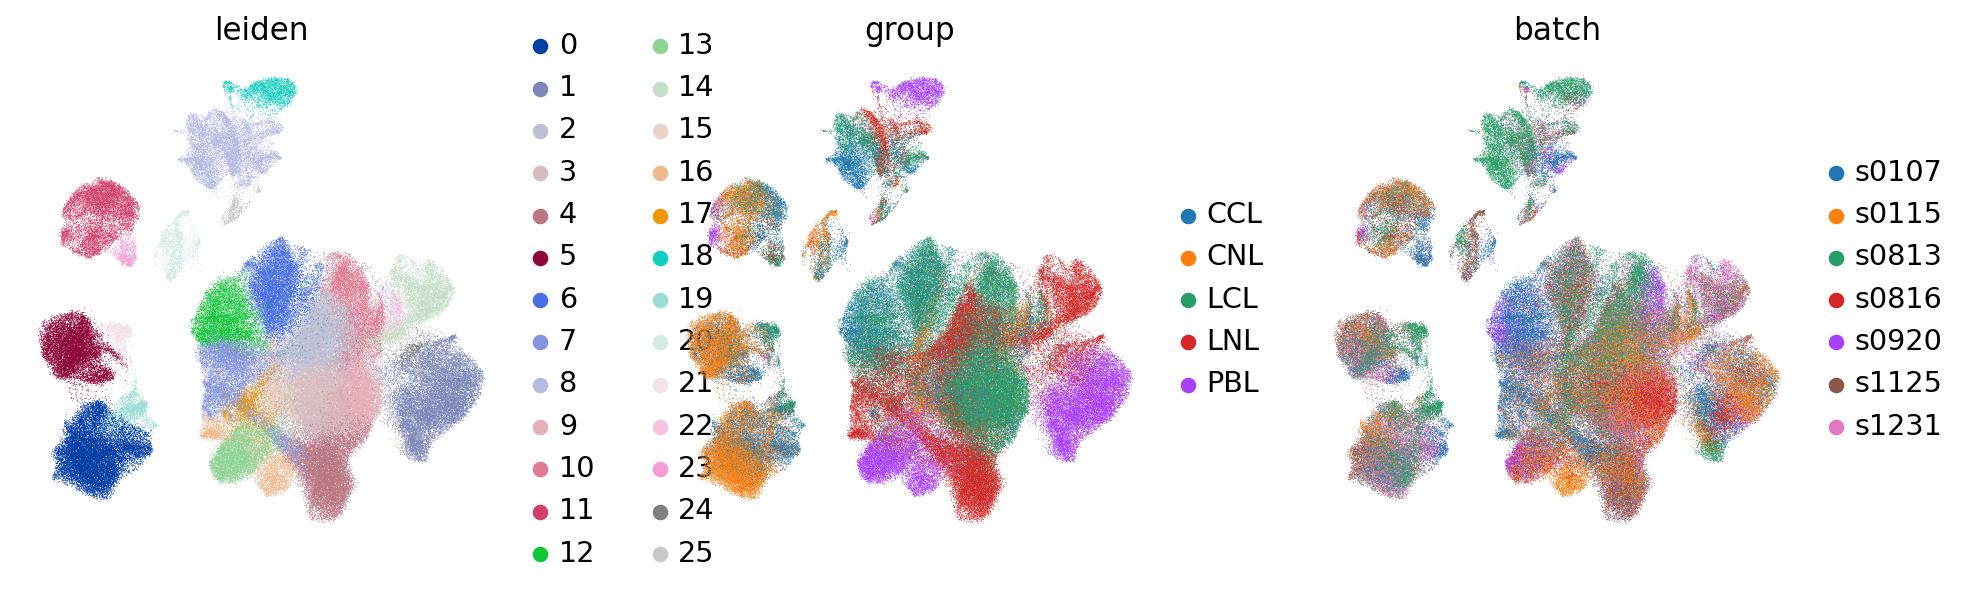

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


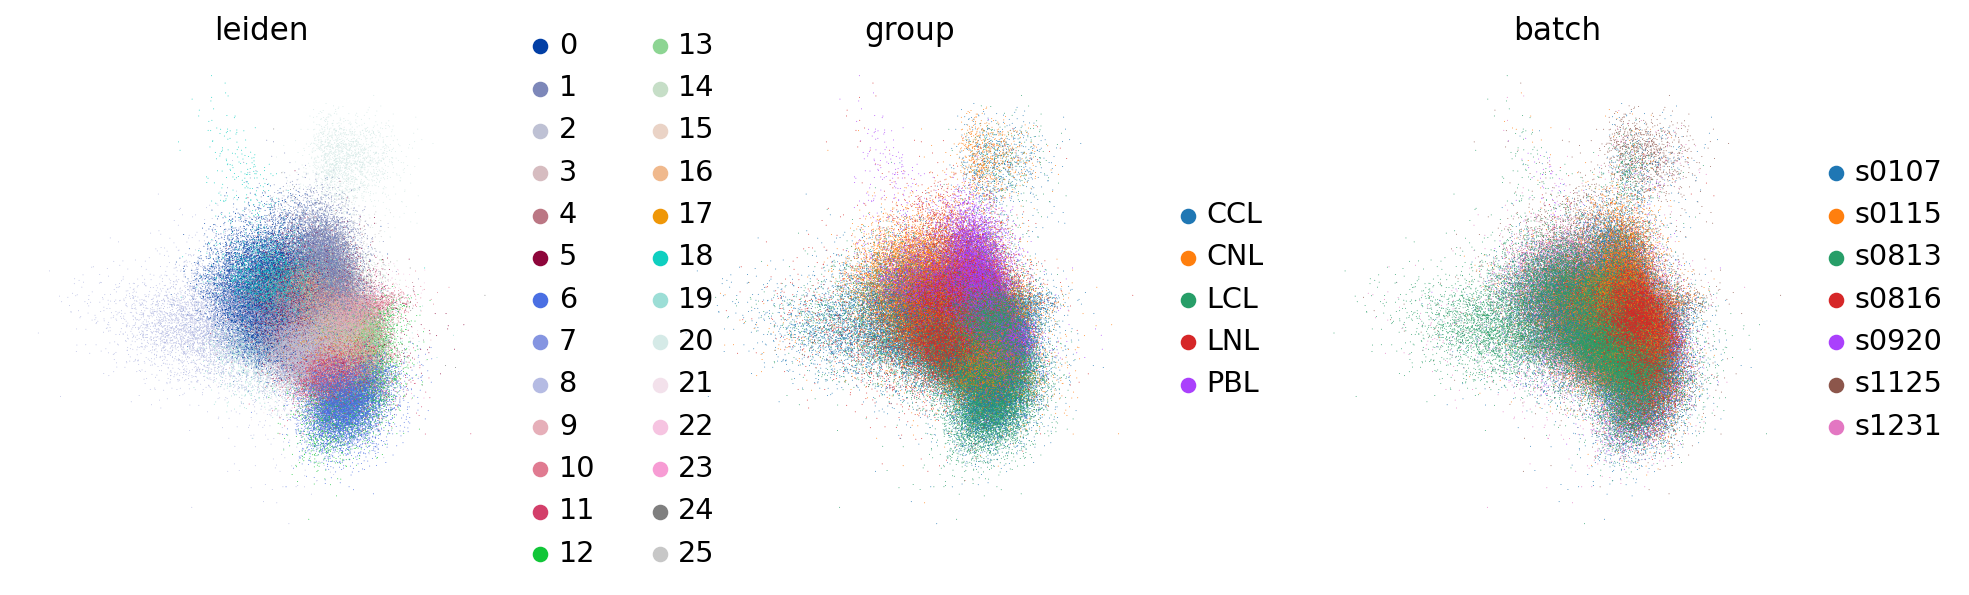

In [ ]:
## 7.4.4 降维聚类可视化批次效应
sc.pl.umap(
    adata_batch,
    color=[
        "leiden",
        "group",
        "batch",
    ],
    wspace=0.2,
    save="-scvi-7.4.4.pdf",
)
sc.pl.pca(
    adata_batch,
    color=[
        "leiden",
        "group",
        "batch",
    ],
    wspace=0.2,
    save="-scvi-7.4.4.pdf",
)
# sc.pl.tsne(adata_batch, color=["leiden", "sample", "group"], save="-scvi-7.4.4.pdf")

In [ ]:
adata_batch.write("anndata_batch_scvi.h5ad", compression="gzip")  # type: ignore

In [ ]:
# ## 7.3.3.1 GPU加速版UMAP
# from scvi.model.utils import mde
# import pymde

# adata_batch.obsm["X_mde"] = mde(adata_batch.obsm["X_scVI"])
# sc.pl.embedding(adata_batch, basis="X_mde", color=["sample", "leiden"], frameon=False, ncols=1,)

In [ ]:
import scanpy as sc

In [ ]:
adata_batch = sc.read("anndata_batch_scvi.h5ad")

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


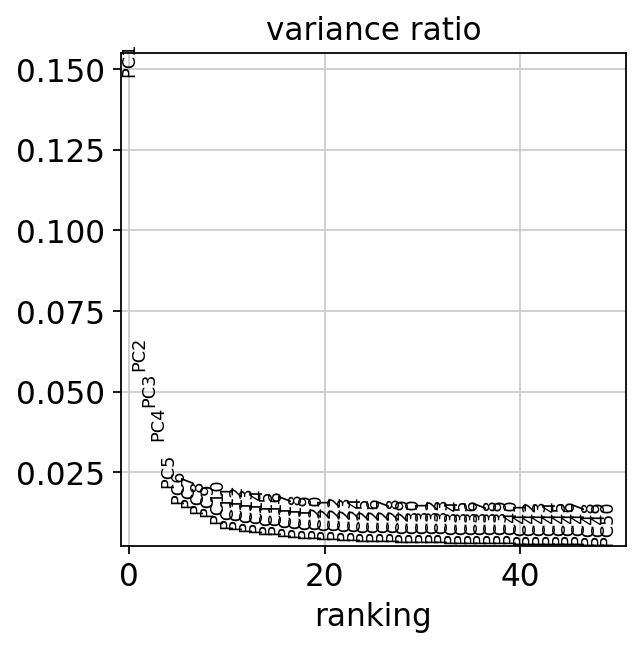

In [ ]:
## 7.4 Harmony去批次
"""Harmon y
    - 稳健性能
    - 无需猜测哪些簇对应于特定细胞类型
    - 这里崩溃可能是openblas，线程数太多不支持
"""
## 7.4.1 预先降维
# 使用反卷积标准化的数据
"""注意文件中的.X的变化,现在是对数化后、反卷积标准化后的数据"""
adata_batch.X = adata_batch.layers["scran_normalization"]

# regressing out 可能会过度校正，见7.5
## sc.pp.regress_out(adata_batch, ["log1p_total_counts_ribo","log1p_total_counts_hb"]) # 可选，修改adata.X，核糖体细胞周期有关
## sc.pp.scale(adata_batch, max_value=10) # 可选，默认修改adata.X，可定义layer
sc.pp.pca(adata_batch, n_comps=50, random_state=123)
sc.pl.pca_variance_ratio(
    adata_batch,
    n_pcs=50,
    # log=True,
    save="-harmony-7.4.1.pdf",
)

In [ ]:
# %%
## 7.4.2 Harmony
import scanpy.external as sce
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUM_THREADS"] = "1"
sce.pp.harmony_integrate(adata_batch, key=["batch", "group"], max_iter_kmeans=100)

# %%
## 7.4.3 整合去批次结果
adata_batch.obsm["X_pca"] = adata_batch.obsm["X_pca_harmony"]
sc.pp.neighbors(adata_batch, n_neighbors=15, n_pcs=10, random_state=123)
sc.tl.leiden(adata_batch, random_state=123)
sc.tl.umap(adata_batch, random_state=123)  # tsne可以指定use_rep，umap不可以，。
# sc.tl.tsne(adata_batch, use_rep="X_pca", random_state=123)

2024-07-30 15:05:19,500 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


: 

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(c

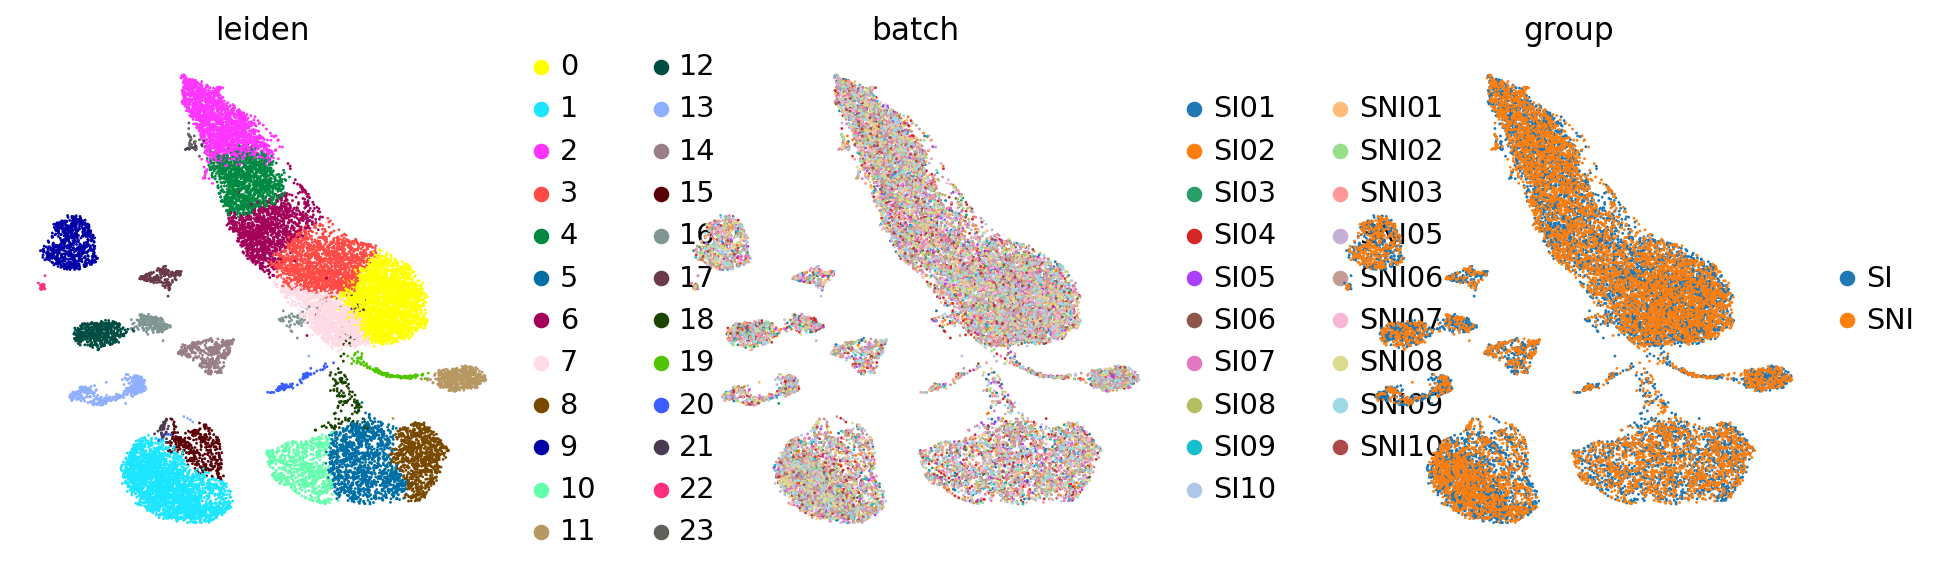

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(c

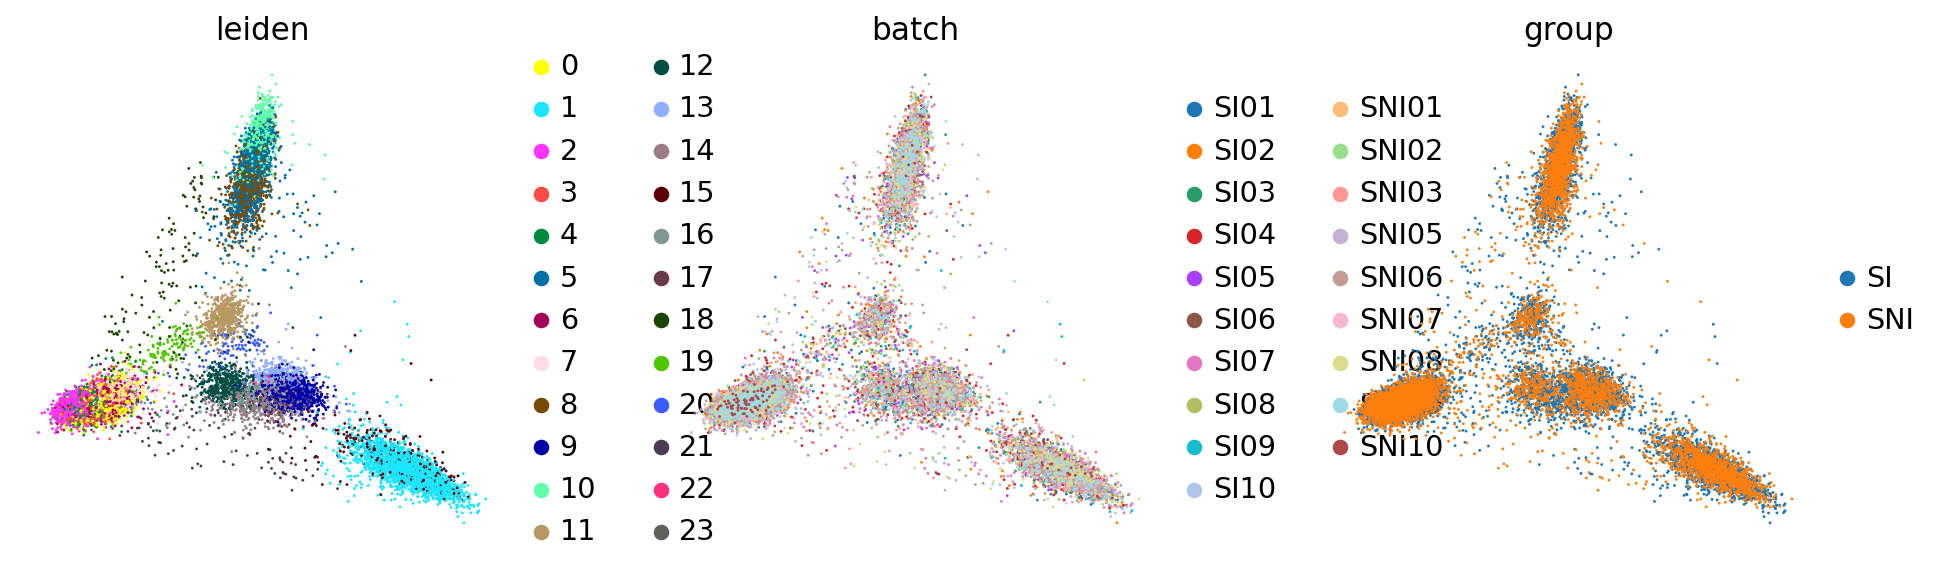

In [ ]:
## 7.4.4 降维聚类可视化批次效应
sc.pl.umap(adata_batch, color=["leiden", "batch", "group"], save="-harmony-7.4.4.pdf")
sc.pl.pca(adata_batch, color=["leiden", "batch", "group"], save="-harmony-7.4.4.pdf")
# sc.pl.tsne(adata_batch, color=["leiden", "batch", "group"], save="-harmony-7.4.4.pdf")

In [ ]:
## 7.5 通过回归处理其他阻塞因素（可选）
""" regress_out 放在去批次前,选择高变基因后好些,不过结果算不上很好
    -------------------------------
    - 去批次是清除系统性差异的一种方法,但是可能还有其他小的阻塞因素。
    - 例如,细胞质量、细胞周期、细胞类型等, 轨迹分析喜欢用。
    - 但是,可能会过度校正
    -------------------------------
    - 不推荐用它来消除批次效应
    - 注意：在使用 sc.pp.regress_out 之前,通常需要对数据进行一些预处理,
    - 如归一化、对数变换等。这样可以确保校正是在合适的数据上执行的。
"""
# sc.pp.regress_out(
#     adata_batch, ["pct_counts_ribo", "pct_counts_mt", "pct_counts_hb"], copy=False
# )

' regress_out 放在去批次前,选择高变基因后好些,不过结果算不上很好\n    -------------------------------\n    - 去批次是清除系统性差异的一种方法,但是可能还有其他小的阻塞因素。\n    - 例如,细胞质量、细胞周期、细胞类型等, 轨迹分析喜欢用。\n    - 但是,可能会过度校正\n    -------------------------------\n    - 不推荐用它来消除批次效应\n    - 注意：在使用 sc.pp.regress_out 之前,通常需要对数据进行一些预处理,\n    - 如归一化、对数变换等。这样可以确保校正是在合适的数据上执行的。\n'

In [ ]:
## 7.6 保存
"""总结
    - 去批次进行了粗浅的降维，聚类
    - 都只是为了可视化批次效应，方便调整方案
"""
adata = adata_batch.copy()
adata.write("anndata_batch.h5ad", compression="gzip")  # type: ignore

: 

In [ ]:
# 人类基因
markers = [
    "CD33",
    "ITGB2",
    "FUT4",
    "CEACAM8",
    "CD14",
    "HLA-DRA",
    "HLA-DRB5",
    "HLA-DRB1",
]

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


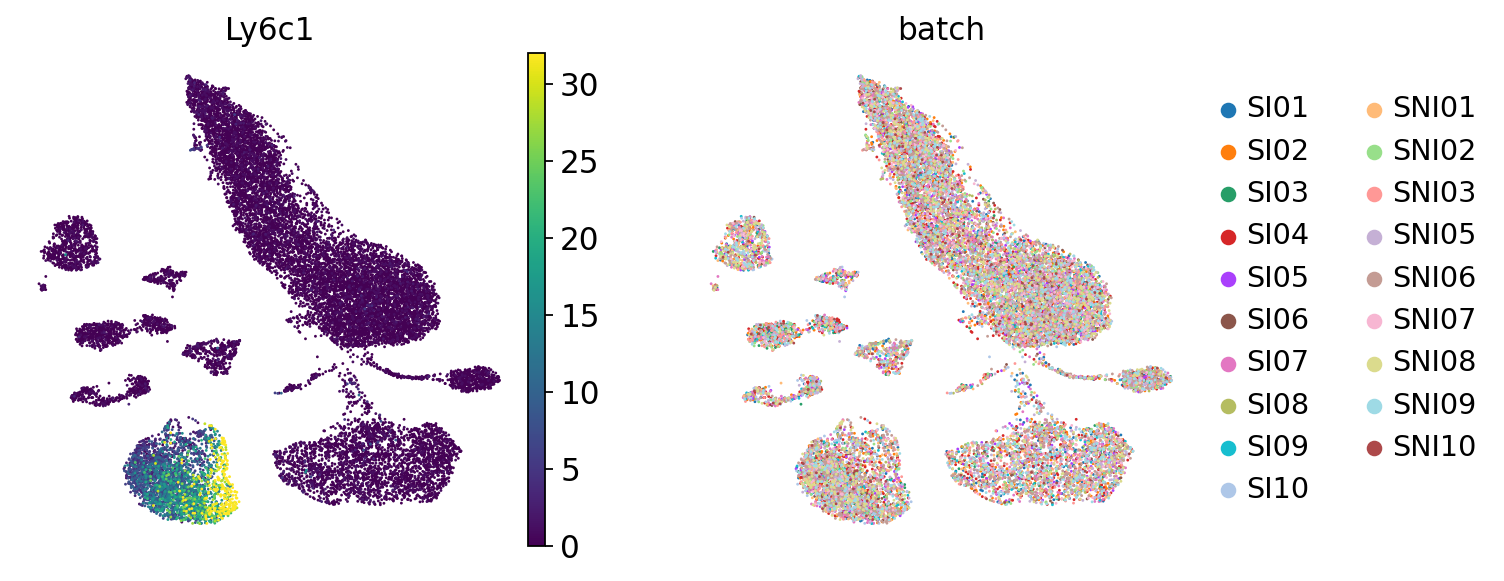

In [ ]:
markers = [
    "CD33",
    "ITGB2",
    "FUT4",
    "CEACAM8",
    "CD14",
    "HLA-DRA",
    "HLA-DRB5",
    "HLA-DRB1",
]
sc.pl.umap(
    adata,
    color=["Ly6c1"] + ["batch"],
    vmin=0,
    vmax="p99",
    save="_marker速览-2.pdf",
    # layer="sqrt_norm",
)